# 1. Load, filter, epoch

In [4]:
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
from preprocess import preprocess
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))# Add the parent directory to the path
from config import data_dir
mne.set_log_level('ERROR')

# load raw data 
subject_id = 317
preprocess = preprocess(data_dir, subject_id)
raw = preprocess.load_data()


# filter the raw data (this is just for visualization purposes)
raw.notch_filter(50, fir_design='firwin', skip_by_annotation='edge')
raw.filter(l_freq=1, h_freq= 30)

# epoch to definition onset (for before and after denoise comparison only , since the sensory evoked potential are more pronounced it can help to )
epochs_def = preprocess.epoching( raw, stim='onset_definition', tmin=-0.4, tmax=1, baseline=(None, 0))

# crop the raw file from stim to response time and concatenate together 
badtrials = []
all_trials_list, stimRT_concat = preprocess.segment_stimRt( raw,badtrials )
stimRT_concat.resample(256) # resample to 256Hz for faster processing

c:\Users\gmoha\Downloads\git\EEG_preprocess\Preprocessing\preprocess.py:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


<RawEDF | A_317_Def_PZ.bdf, 129 x 76328 (298.2 s), ~75.3 MiB, data loaded>

# 2. Selection of noisy channels

## 2.1 pyprep automatic detection of noisy channels

We can use pyprep to detect noisy channels automatically, it is not perfect but it can help to detect some noisy channels that might be missed by manual inspection. If the dataset is large we can of course only use the automatic detection and skip the manual inspection step.


In [5]:
from pyprep.find_noisy_channels import NoisyChannels
det = NoisyChannels(stimRT_concat, do_detrend=False) # put do_detrend=True if you did not high-pass filter the data
det.find_all_bads(ransac=False)
bad_ch = det.get_bads(as_dict=True)
bad_ch

{'bad_by_nan': [],
 'bad_by_flat': [],
 'bad_by_deviation': [],
 'bad_by_hf_noise': [],
 'bad_by_correlation': ['A4', 'B26'],
 'bad_by_SNR': [],
 'bad_by_dropout': [],
 'bad_by_ransac': [],
 'bad_all': ['A4', 'B26']}

## 2.2 Manual inspection of channels

For manual inspection we  look at the **ERP**, the average **PSD**, and finally a quick look and **raw time-series** data

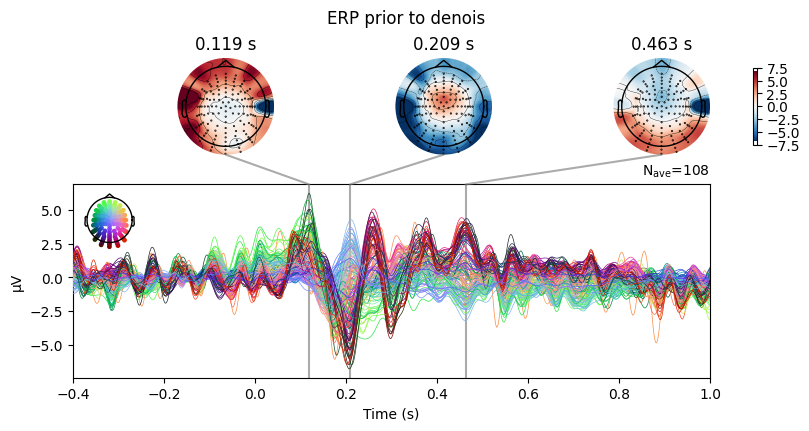

In [4]:
# plot erp 
# use qt to have interactive plots 
%matplotlib inline 
fig = epochs_def.average().plot_joint( title='ERP prior to denois', ts_args=dict(time_unit='s'), topomap_args=dict(time_unit='s'), show = False)

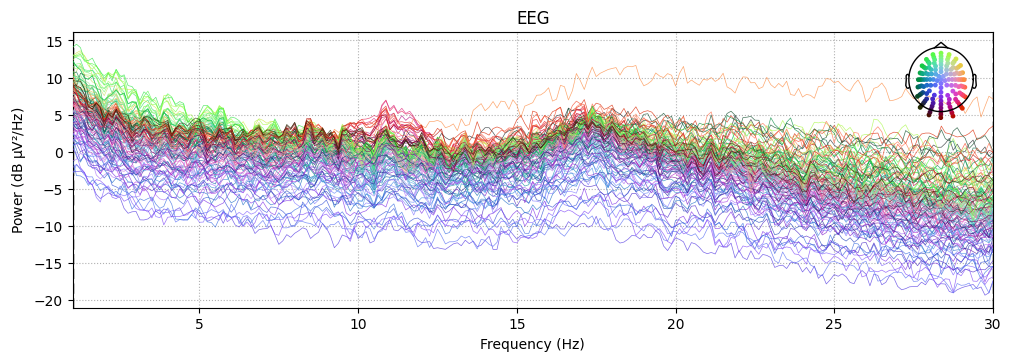

In [7]:
%matplotlib qt
stimRT_concat.plot_psd(fmin = 1, fmax = 30)

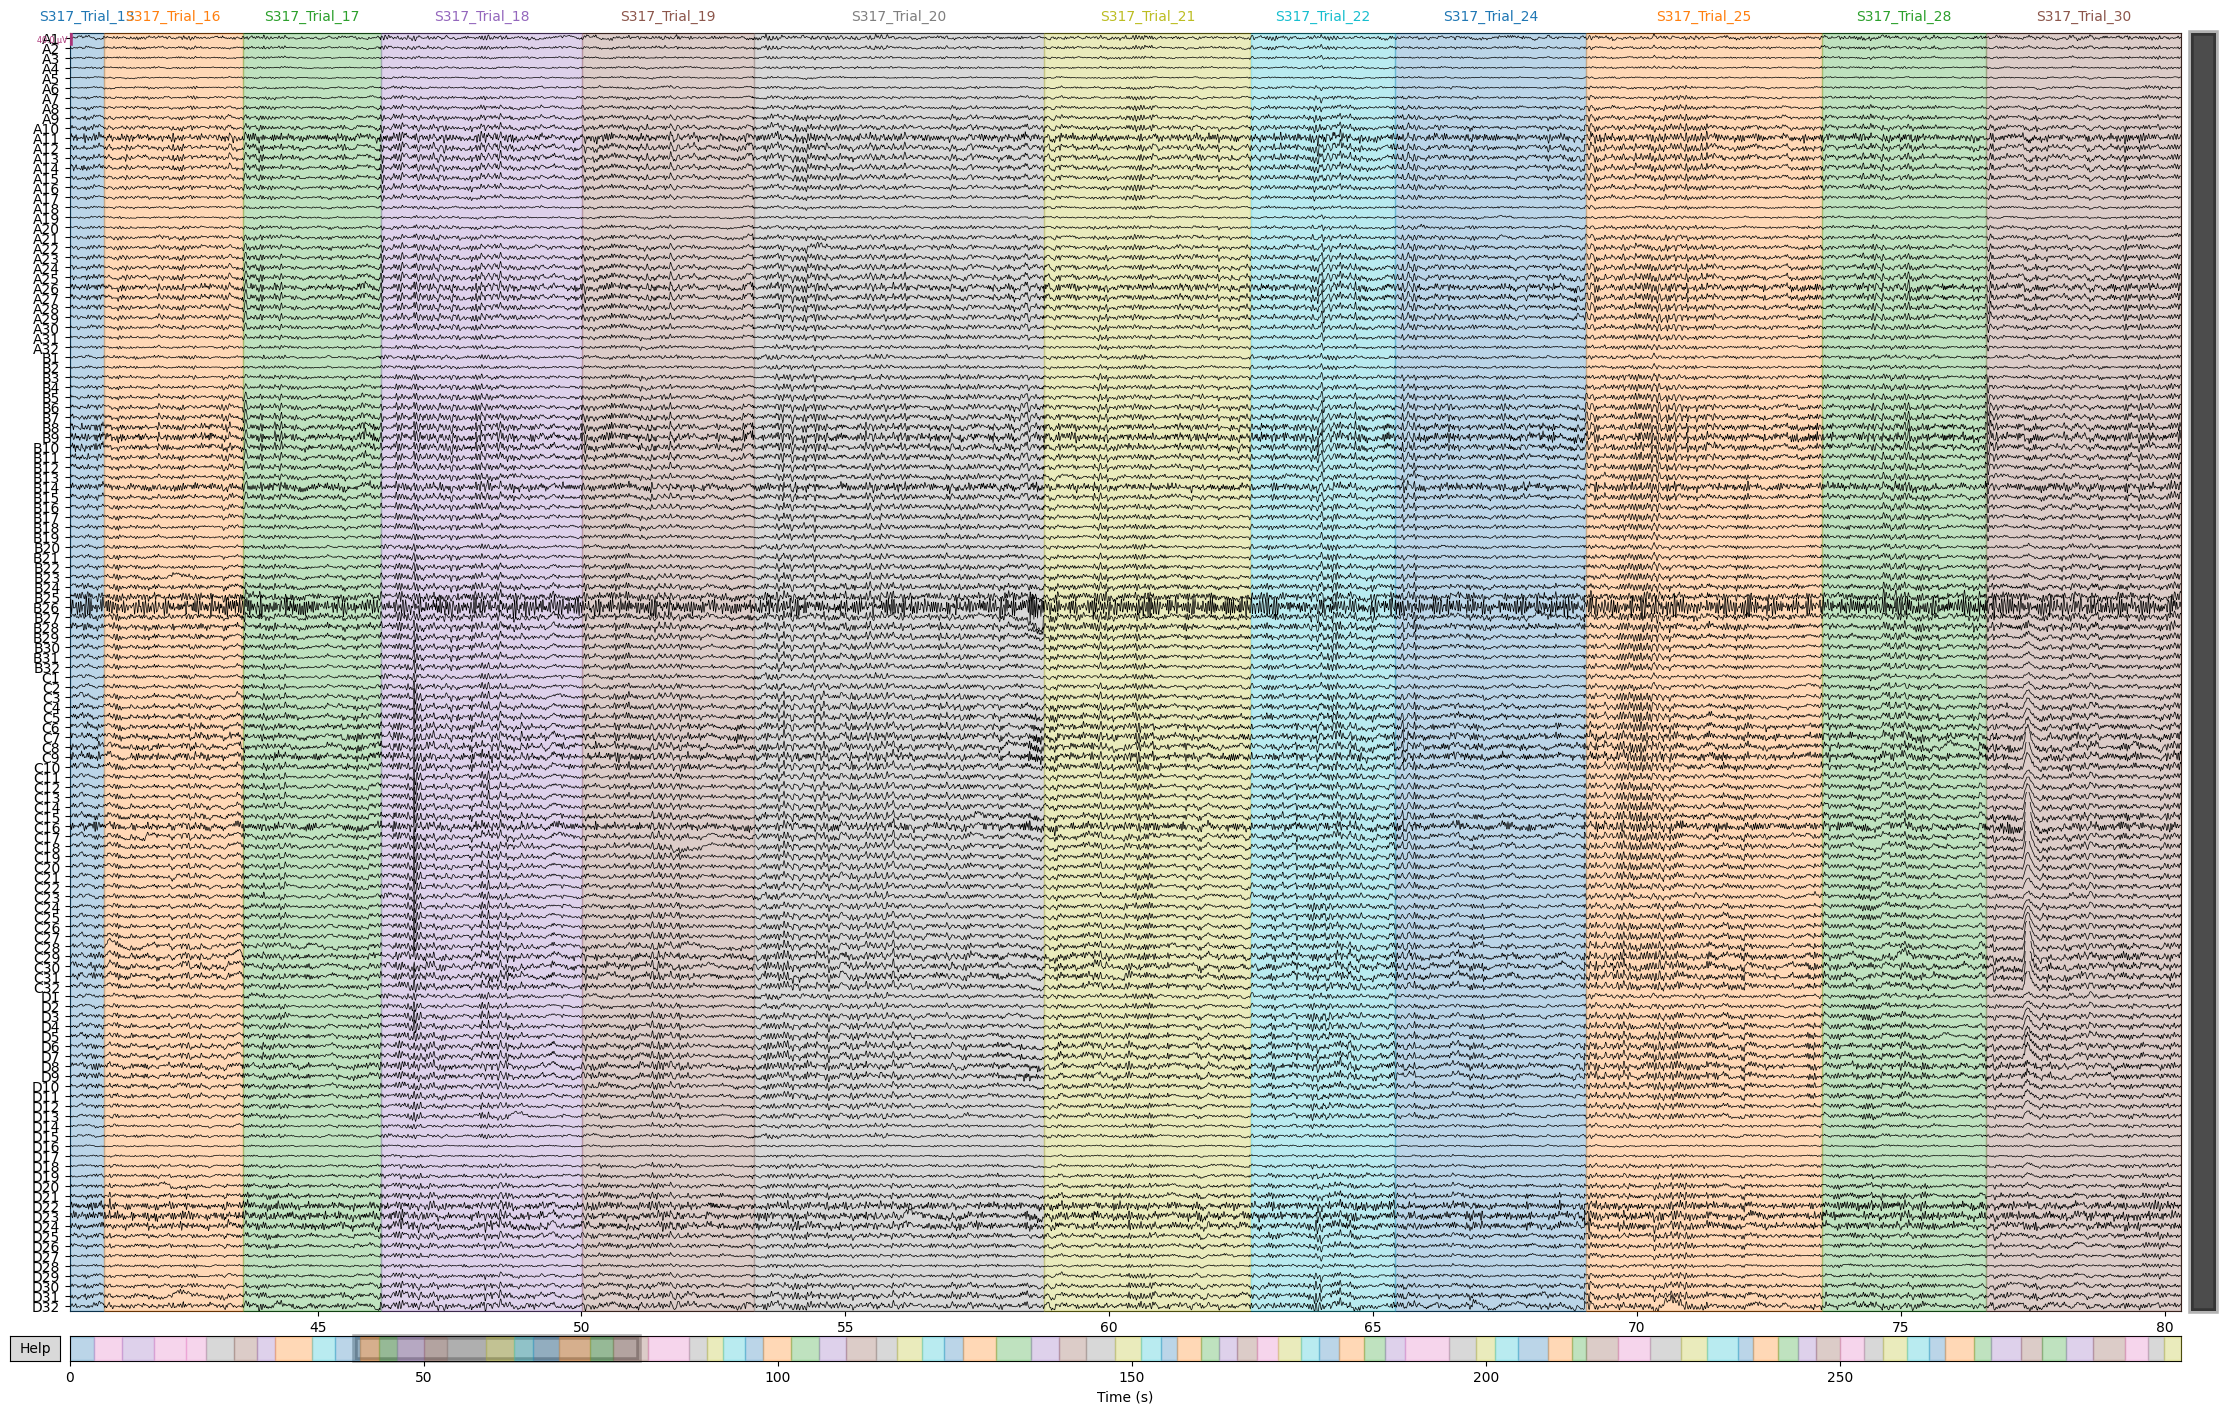

In [8]:
%matplotlib qt 
stimRT_concat.plot( n_channels=128, scalings=dict(eeg=20e-6), picks = 'eeg', duration = 40, block = True)


# 3.Selection of noisy Trials
we will do a quick manual inspection of trials and select the trials that are noisy. This step is necessary for the further steps that use automatic detection of noisy trials.

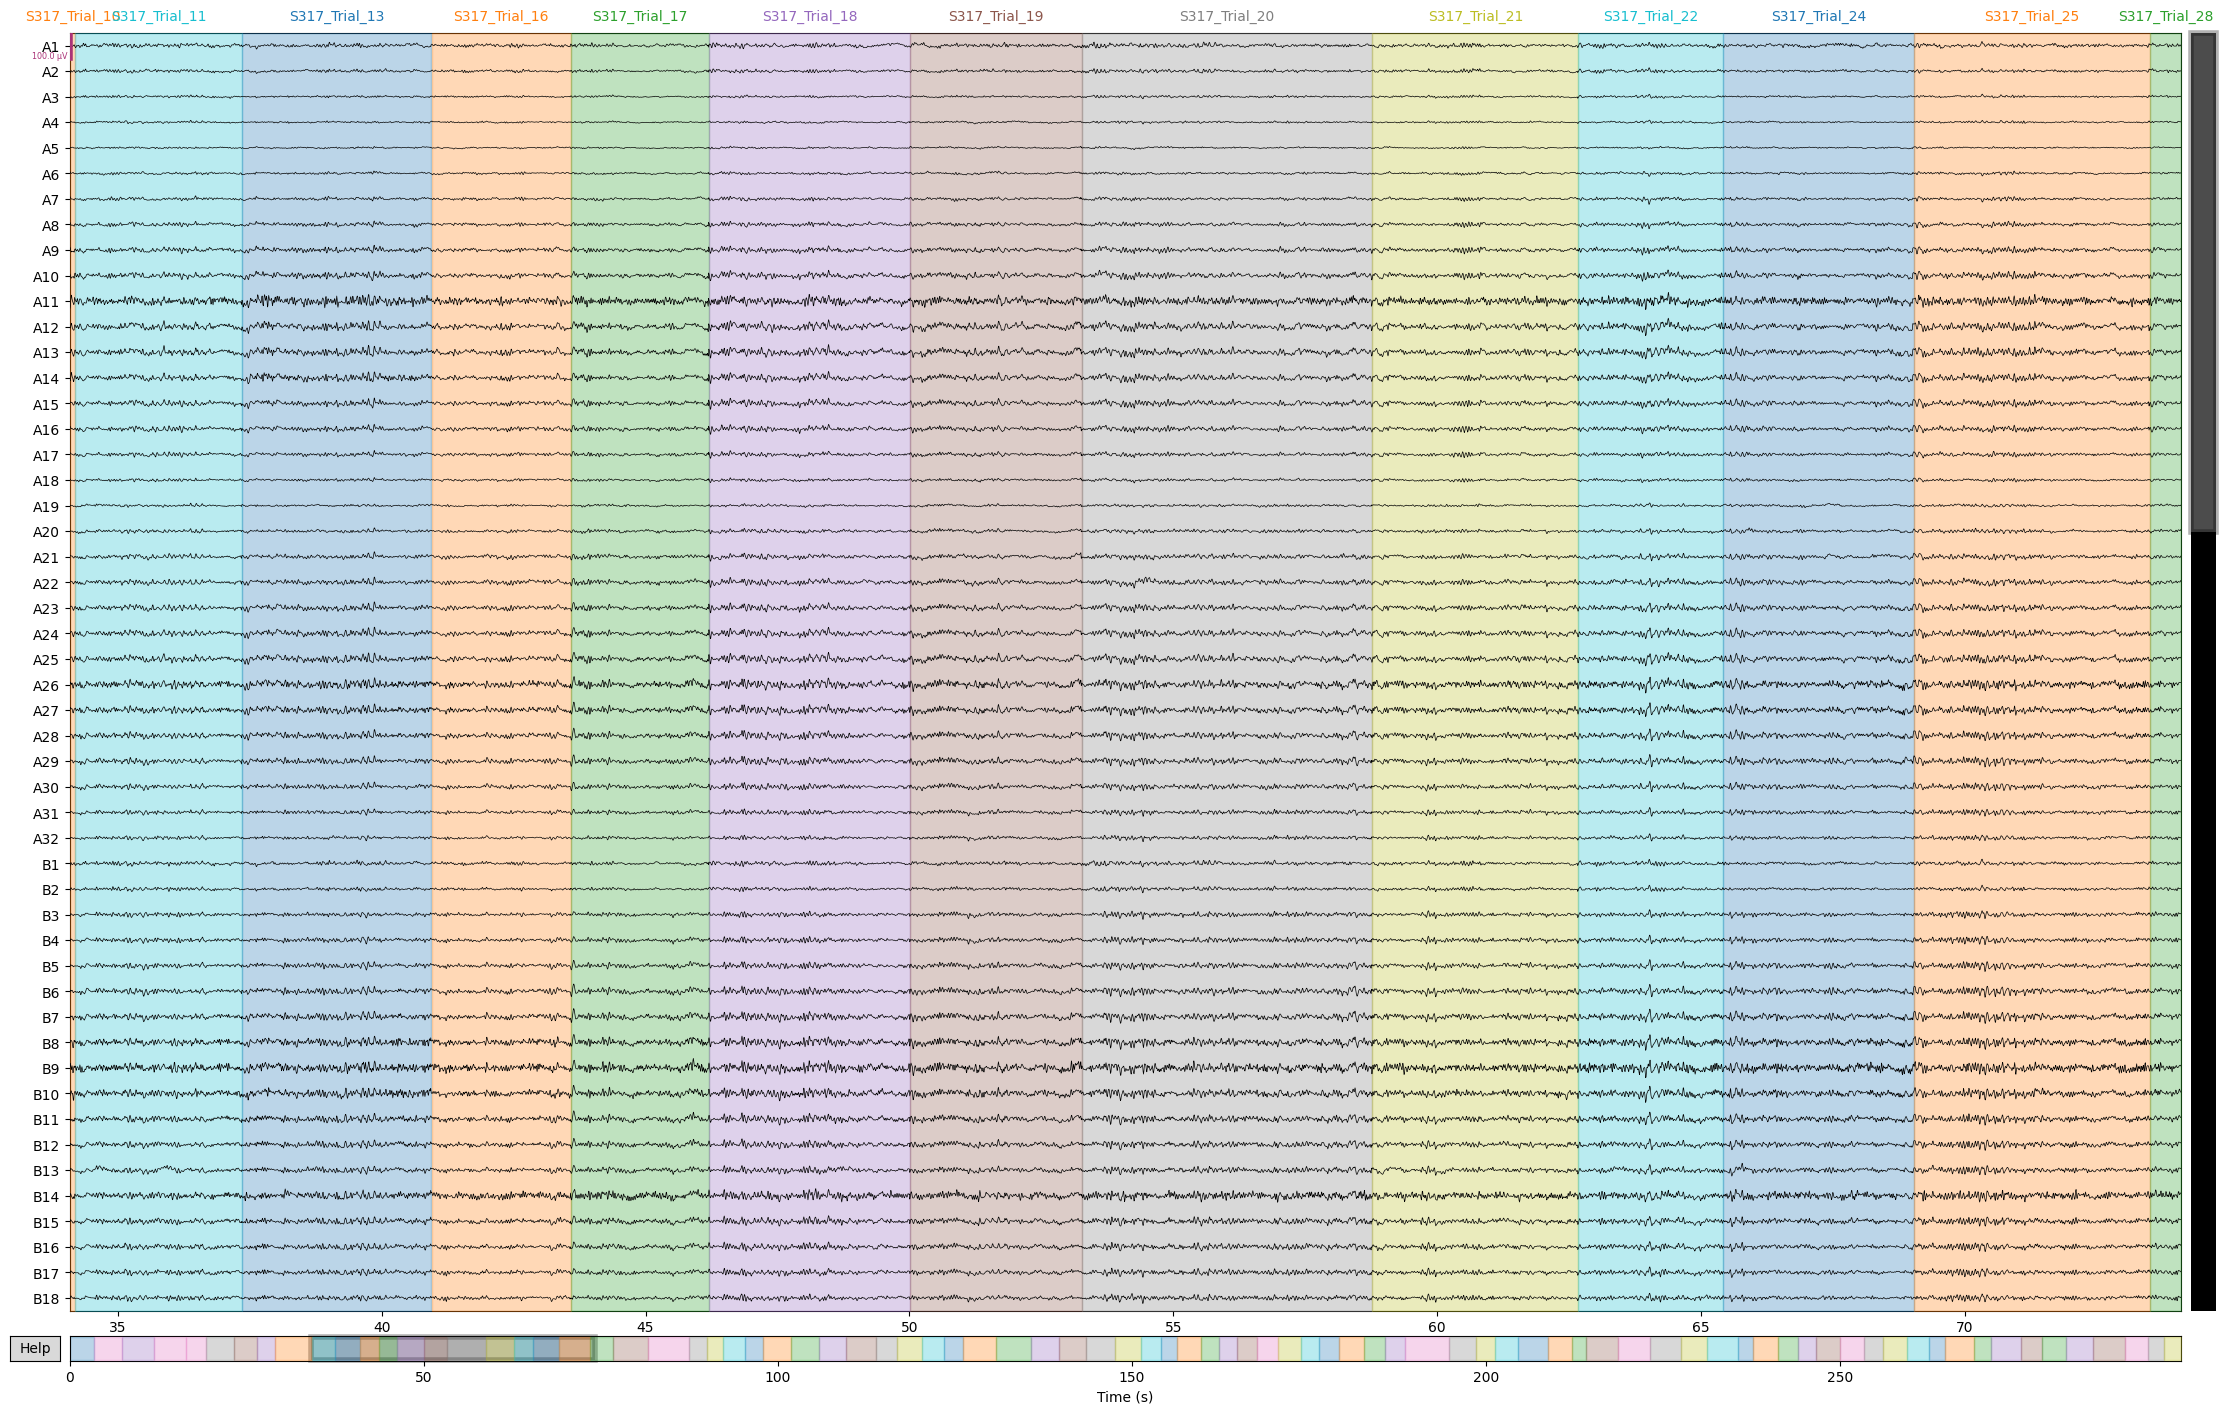

In [9]:
%matplotlib qt 
stimRT_concat.plot( n_channels=50, scalings=dict(eeg=50e-6), picks = 'eeg', duration = 40, block = True)

## save the manually selected noisy channels and trials 
we will save the manually selected noisy channels and trials in a one pickle file for all subjects.

In [ ]:
# load the selected bad channels
from config import data_dir
with open(os.path.join(data_dir, 'BadTrialsChannel_manualDetected.pkl'), "rb") as f:
    detected_noise = pickle.load(f)
detected_noise[subject_id]
detected_noise[subject_id]['channel_names'] =['B9', 'B26', 'D23'] # add the bad channels 
detected_noise[subject_id]['trial_numbers'] = [] # add the bad trials
detected_noise[subject_id]
# save the selected bad channels
with open(os.path.join(data_dir 'BadTrialsChannel_manualDetected.pkl'), "wb") as f:
    pickle.dump(detected_noise, f)

{'channel_names': ['B9', 'B26', 'D23'],
 'trial_numbers': [],
 'noisy_components': [1]}

Plot the ERP after removing the noisy channels and trials.

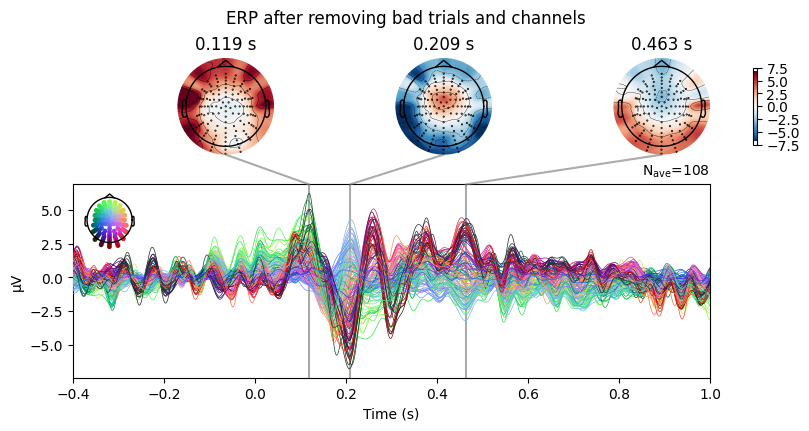

In [15]:
bad_trials = detected_noise[subject_id]['trial_numbers']

# remove the bad channels and trials
epochs_def.drop_channels(detected_noise[subject_id]['channel_names'])
epochs_def.drop(bad_trials)

# plot erp 
%matplotlib inline
fig = epochs_def.average().plot_joint( title='ERP after removing bad trials and channels', ts_args=dict(time_unit='s'), topomap_args=dict(time_unit='s'), show = False)

# 4. compute ICA and select bad components
the ICA_denoise pipline : 

raw -> remove manually seleceted noisy channels -> filter (1- None) -> segment the data from stim to response -> remove manually selceted noisy trial -> interpolate bridged channels -> compute ICA


In [6]:
import sys
import os
import numpy as np
import mne
import pickle


mne.set_log_level('ERROR')
subject_id = 317
# compute ica and save it 
preprocess.ICA_denoise( lowPassFilter = None, n_components=None, decim=2, ica_name = 'ica_infomax', overwrite = False)

ICA already exists for subject 317, skipping ICA computation.


In [ ]:
from config import data_dir
pre_ica = preprocess.pre_ica_denoise( 30, prestim_duration=0.3)
path_ic = os.path.join(data_dir, f'S{subject_id}_ica_infomax.fif')
ica = mne.preprocessing.read_ica(path_ic)
# epoch data only for visualization
events, event_id = mne.events_from_annotations(pre_ica)
tmin, tmax = 0, 2  # in seconds, relative to stim onset
epochs = mne.Epochs(pre_ica,events,event_id=event_id,tmin=tmin,tmax=tmax,
                     baseline= (0,0.3),      # e.g. baseline‐correct to the pre‐onset period
preload=True,
)
evoked = epochs.average()

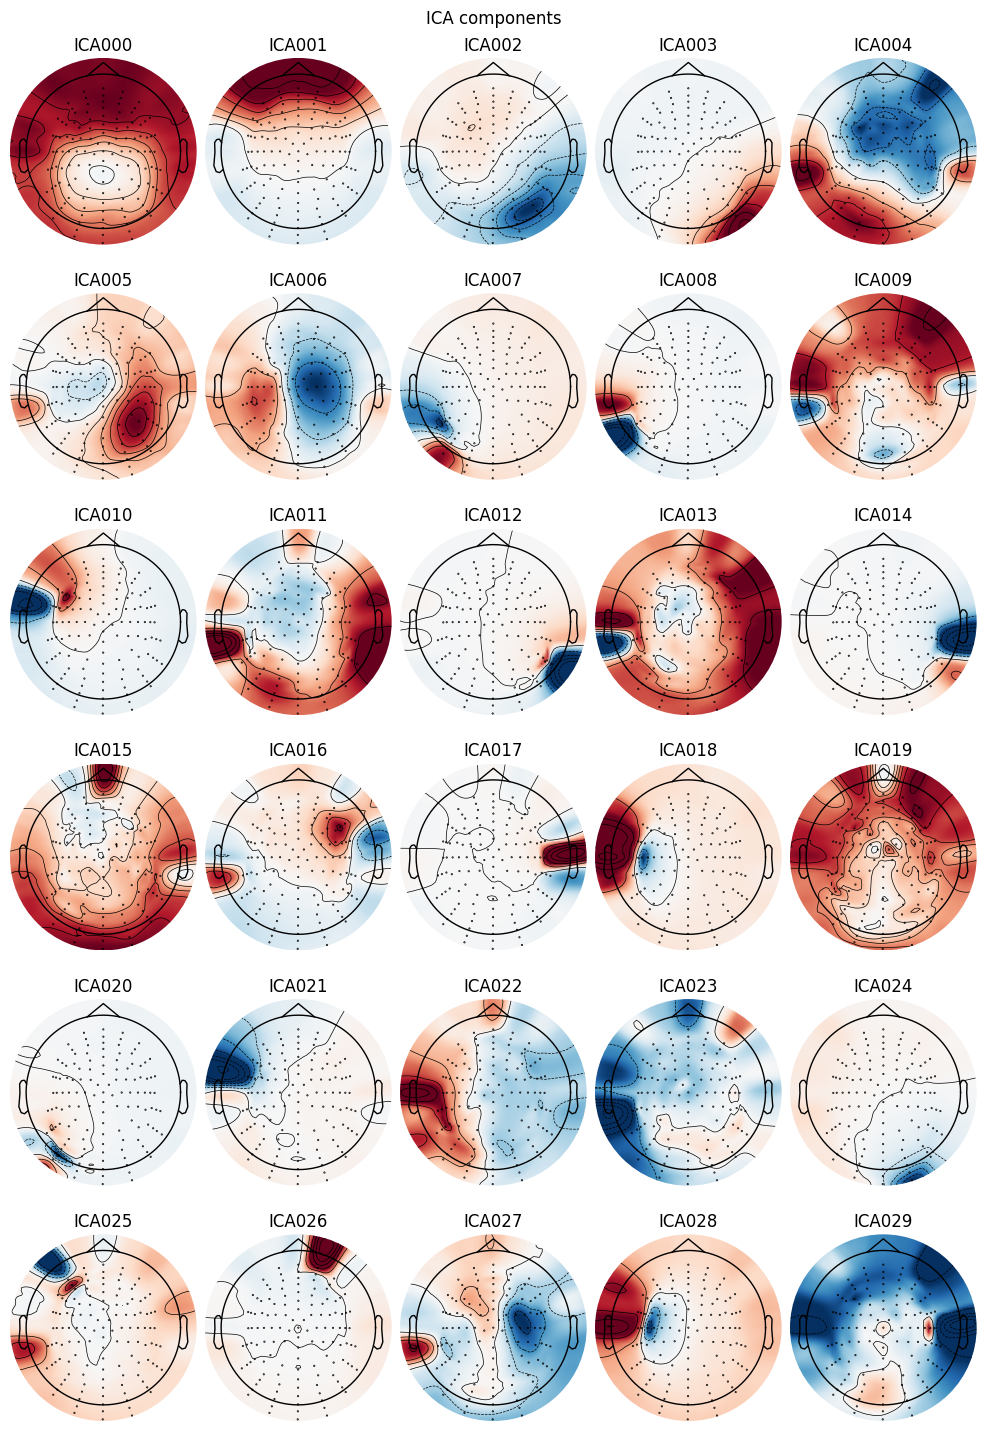

In [6]:
%matplotlib qt
ica.plot_components(inst = epochs, picks = np.arange(0, 30))


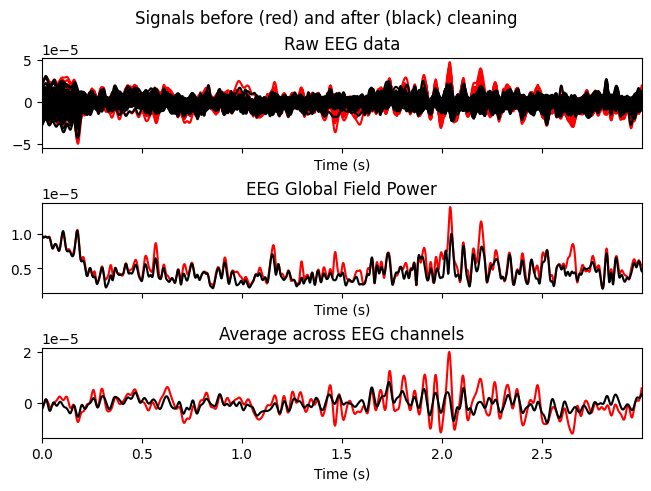

In [10]:
%matplotlib inline
bad_ics = [1]
f =ica.plot_overlay(pre_ica, exclude= bad_ics)

## save the noisy components selected

In [14]:
# load the selected bad channels
from config import data_dir
with open(os.path.join(data_dir, 'BadTrialsChannel_manualDetected.pkl'), "rb") as f:
    detected_noise = pickle.load(f)
detected_noise[subject_id]['noisy_components'] =[1] # add the bad components
print(detected_noise[subject_id])
# save the selected bad channels
with open(os.path.join(data_dir, "BadTrialsChannel_manualDetected.pkl"), "wb") as f:
    pickle.dump(detected_noise, f)

{'channel_names': ['B9', 'B26', 'D23'], 'trial_numbers': [], 'noisy_components': [1]}


# 5. Autoreject 

### preparation from the raw data

In [ ]:
import sys
import os
import numpy as np
import mne
import pickle
from preprocess import preprocess
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))# Add the parent directory to the path
from config import data_dir
mne.set_log_level('ERROR')

stim = 'onset_definition'



# load the selected bad channels, trials and components
with open(os.path.join(data_dir, 'BadTrialsChannel_manualDetected.pkl'), "rb") as f:
    all_bads = pickle.load(f)
bads_channel = all_bads[subject_id]['channel_names']
bad_trials = all_bads[subject_id]['trial_numbers']
noisy_components = all_bads[subject_id]['noisy_components']

preprocess = preprocess(data_dir, subject_id)
# load raw data
raw = preprocess.load_data()
# Get bridged channels
epochs = preprocess.epoching(raw, stim=stim, tmin=-0.5, tmax=0.2)  # a random epoch just for computing the bridged channels
bridged_idx, ed_matrix, bridged_ch_names = preprocess.bridged_channels(epochs, lm_cutoff=5, epoch_threshold=0.5)

# 1. remove noisy channels
raw.info['bads'] = bads_channel

# 2. Filter the data
raw.notch_filter([50, 100], fir_design='firwin', skip_by_annotation='edge')
raw.filter(l_freq=1, h_freq=30)

# 3. epoch the data and remove bad trials
meta_data = preprocess.load_trials_metadata()
epochs = preprocess.epoching(raw, stim=stim, tmin=-0.5, tmax=2, baseline=None, metadata=meta_data)

# we get new metadata from the epochs because at epoching step there might be some trials that are automatically dropped because of length for example
# so we need to reset the index of the metadata
meta_data = epochs.metadata
meta_data = meta_data.reset_index(drop=True)

# bad indices
bad_indices = meta_data[meta_data['Ordre'].isin(bad_trials)].index
na_indices = meta_data[meta_data['RT_Correct_CorrPU'].isna()].index
# Combine bad indices
remove_indices = bad_indices.union(na_indices)
# Remove trials (manual selected noisy trials and trials with NaN RT_Correct_CorrPU)
epochs.drop(remove_indices)

# 4. remove noisy components
path_ic = os.path.join(data_dir, f'S{subject_id}_ica_infomax.fif')
ica = mne.preprocessing.read_ica(path_ic)
ica.exclude = noisy_components
ica.apply(epochs, exclude=noisy_components)

### applying autoreject

In [ ]:
n_jobs = 1 
# 5. autoreject
import autoreject  # version 0.3.1 https://autoreject.github.io/
ar = autoreject.AutoReject(consensus=np.linspace(0, .4, 11), n_jobs=n_jobs, picks='eeg')
ar.fit(epochs)  
epochs_ar, reject_log = ar.transform(epochs, return_log=True)
mat = np.delete(reject_log.labels, reject_log.bad_epochs, axis=0)
percentage_interp = (mat == 2).sum() / mat.size * 100